### Preprocesamiento de imágenes médicas

#### Librerías de interés

In [13]:
!pip install SimpleITK
!pip install itk-elastix
!pip install nilearn
!pip install medpy

## Filtrado de imágenes

*   Filtro de mediana




In [18]:
import SimpleITK as sitk
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from nilearn import image,plotting
import numpy as np
import itk
import os

## Implementación de Filtros de Mediana y Gaussian

*   Funcionamiento del Filtro de Mediana: Se visita cada píxel de la imagen y se reemplaza por la mediana de los píxeles vecinos. La mediana se calcula ordenando los valores de los píxeles vecinos y seleccionando el valor que queda en el medio. Da muy buenos resultados en caso de ruido sal y pimienta.







Para implementar los diferentes filtros, se procede a crear una función que se encargará de aplicar uno u otro según las necesidades del usuario, teniendo en cuenta todos los argumentos de las funciones antes mencionadas.

In [1]:
def FuncionFiltros(TipoFiltro,Directorio,Arreglo=None,sigma=None,Graficar=1,Guardar=1,Factor_brillo=1.5,cortes_z=[18, 31, 51, 64, 76,93,160]):
    
    # Argumentos de la función y el tipo de variable que representa:
    #- TipoFiltro (int): Indica el tipo de filtro a aplicar. 1 para filtro de mediana, 0 para filtro gaussiano.
    #- Directorio (str): La ruta o nombre de archivo de la imagen a filtrar.
    #- Arreglo (list, opcional): Arreglo de proximidad para el filtro de mediana. Por defecto es None, pero al momento de usar el filtro de mediana, el usuario debe ingresar una lista de tres dimensiones de manera obligatoria, ya que esta lista representa el número de vecinos a considerar para el filtro, por ejemplo: [1, 1, 1].
    #- sigma (float, opcional): Valor del parámetro sigma para el filtro gaussiano. Por defecto es None, pero al momento de usar el filtro gaussiano, el usuario debe proporcionar obligatoriamente el valor, ya sea entero o decimal.
    #- Graficar (int, opcional): Si es 1, se generará una visualización de las imágenes original y filtrada. Por defecto es 1.
    #- Guardar (int, opcional): Si es 1, se guardará la imagen filtrada en el directorio actual. Por defecto es 1.
    #- Factor_brillo (float, opcional): Factor de brillo aplicado a la imagen. Por defecto es 1.5.
    #- cortes_z (list, opcional): Lista de coordenadas z para los cortes de la visualización. Por defecto son [18, 31, 51, 64, 76, 93, 160].
    
    if (TipoFiltro==0):
        
        # Ejecutarel  Filtro Gaussiano

        # Cargar la imagen
        imagen = image.load_img(Directorio)
        
        # Se Obtienen los datos de la imagen 
        imagen_data = imagen.get_fdata()
        # Aplicar el filtro gaussiano
        imagen_filtrada_data = gaussian_filter(imagen_data, sigma)
        # Aplicar el factor de brillo
        imagen_filtrada_gaussiano = np.clip(imagen_filtrada_data*Factor_brillo, 0, 255)
        ImagenOriginalBrillo = np.clip(imagen_data*Factor_brillo, 0, 255)

        # Crear imágenes con brillo ajustado,como imagen sin brillo 
        imagen_filtrada = image.new_img_like(imagen, imagen_filtrada_data)
        imagen_filtradBrillo = image.new_img_like(imagen, imagen_filtrada_gaussiano)
        ImagenOriginalBrillo = image.new_img_like(imagen, ImagenOriginalBrillo)
        
        # Guardar la imagen filtrada si guardar es iguial a 1
        if Guardar==1:
            imagen_filtrada.to_filename("imagen_Filtrada_Gaussian.nii.gz")
    
        # Título para la imagen original con brillo ajustado
        tituloOriginal="Imagen Original a "+str(Factor_brillo)+" de Brillo"
        titulofiltro='Filtro Gaussiano valor de sigma: '+str(sigma)
        
    elif(TipoFiltro==1):
        # Ejecutar el filtro de mediana 
        
        #Se procede a leer el archivo de imagen proporcionado por la variable 'Directorio'
        imagen = sitk.ReadImage(Directorio)
        
        # Implementar el filtro de Mediana teniendo en cuenta el arreglo proporcionado
        imagen_filtrada_Mediana= sitk.Median(imagen,Arreglo)
        
        # Guardar la imagen filtrada incluso si el valor de guardar es 0. En caso de ser 0, el archivo se borra posteriormente.
        sitk.WriteImage(imagen_filtrada_Mediana, "imagen_Filtrada_Mediana.nii.gz")
        
        # Cargar las imágenes para su visualización original como la del filtro de mediana
        imagen_filtrada_Mediana = image.load_img('imagen_filtrada_Mediana.nii.gz')
        imagen_original = image.load_img(Directorio)
        
        # Se Obtienen los datos de ambas imágenes
        ImagenFiltradaMediana=imagen_filtrada_Mediana.get_fdata()
        ImagenOriginal= imagen_original.get_fdata()

        # Aplicar el factor de brillo a las imágenes
        FiltroMedianaBrillo = np.clip(ImagenFiltradaMediana*Factor_brillo, 0, 255)
        ImagenOriginalBrillo = np.clip(ImagenOriginal*Factor_brillo, 0, 255)
        
        # Crear imágenes con brillo ajustado
        imagen_brillanteFiltromediana = image.new_img_like(imagen_filtrada_Mediana,FiltroMedianaBrillo)
        imagen_brillanteimagen_original = image.new_img_like(imagen_original,ImagenOriginalBrillo)
        
        # Título para la imagen original con brillo ajustado
        tituloOriginal="Imagen Original a "+str(Factor_brillo)+" de Brillo"
        titulofiltro='Filtro Mediana '+'Arreglo '+str(Arreglo)
        ImagenOriginalBrillo=imagen_brillanteimagen_original
        imagen_filtradBrillo=imagen_brillanteFiltromediana
        # Eliminar la imagen filtrada si Guardar es igual a cero en caso contrario se mantiene la imagen sin el brillo 
        if Guardar==0:
            os.remove("imagen_Filtrada_Mediana.nii.gz")

    if Graficar==1:
        for corte_z in cortes_z:   
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            plotting.plot_anat(imagen_filtradBrillo , title= titulofiltro, dim=0, display_mode='z', cut_coords=[corte_z],axes=axes[1])
            plotting.plot_anat(ImagenOriginalBrillo, title=tituloOriginal, dim=0, display_mode='z',cut_coords=[corte_z], axes=axes[0])
        plt.show()
   
    
# NOTA: Es importante aclarar que la imagen que se guarda es una imagen sin el aumento de intensidad (+brillo), ya que esta opción solo sirve para mejorar la visualización de las imágenes O analizar.
#Ejemplo de uso:
#FuncionFiltros(0,"C:/Users/andre/Desktop/Imagenes/filtrado-registro/SubjectA_T1.nii.gz",sigma=1,Guardar=1,Graficar=0)
#FuncionFiltros(1,"SubjectA_T2.nii.gz", Arreglo=[1,1,1], Graficar=1, Guardar=1, Factor_brillo=1.2,cortes_z=[18, 31, 51])

En las diferentes implementaciones de los dos filtros se trabajará solo con 2 cortes, debido a que en estos se observa una intensidad de ruido significativo. Los cortes seleccionados son el 18 y el 51.

IMPLEMENTACION DEL FILTRO GAUSSIANO CON DIFERENTES VALORES DE SIGMA

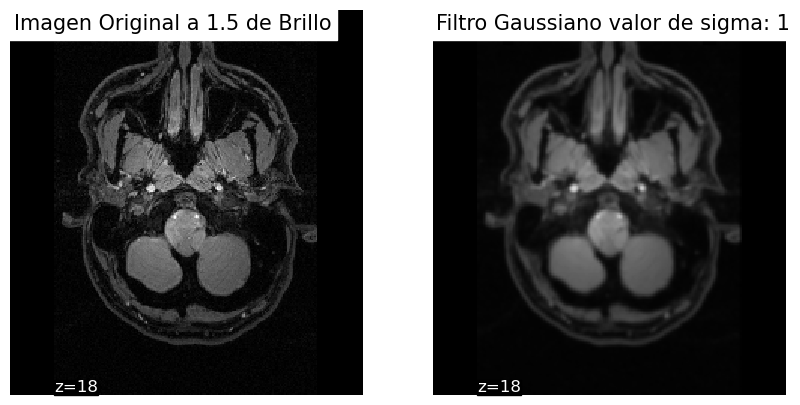

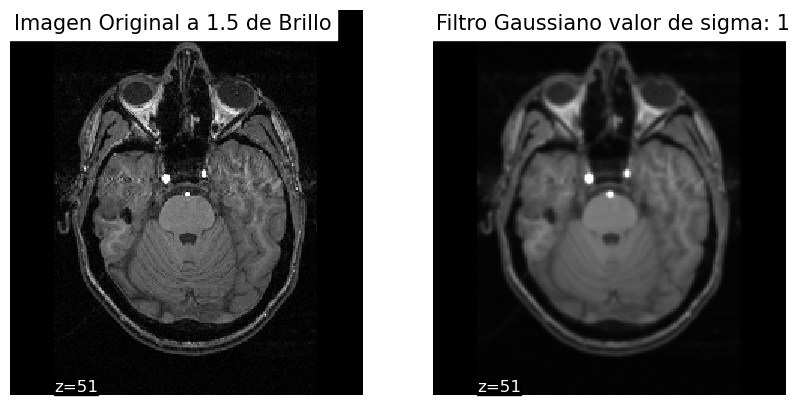

In [19]:
FuncionFiltros(0,"SubjectA_T1.nii.gz",sigma=1,Guardar=0,Graficar=1,cortes_z=[18,51])

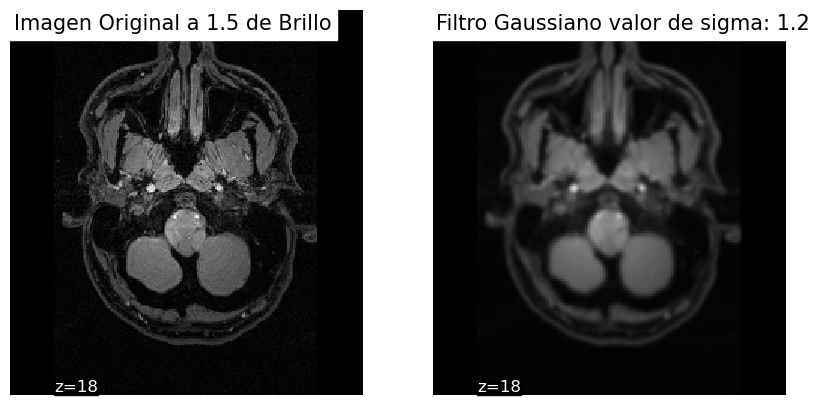

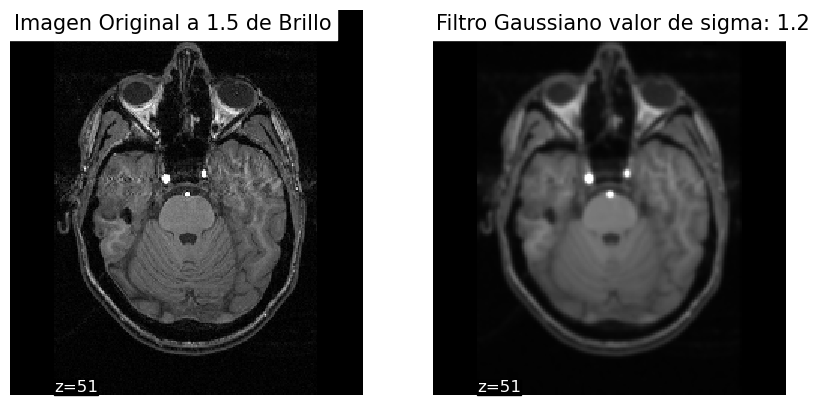

In [21]:
FuncionFiltros(0,"SubjectA_T1.nii.gz",sigma=1.2,Guardar=0,Graficar=1,cortes_z=[18,51])

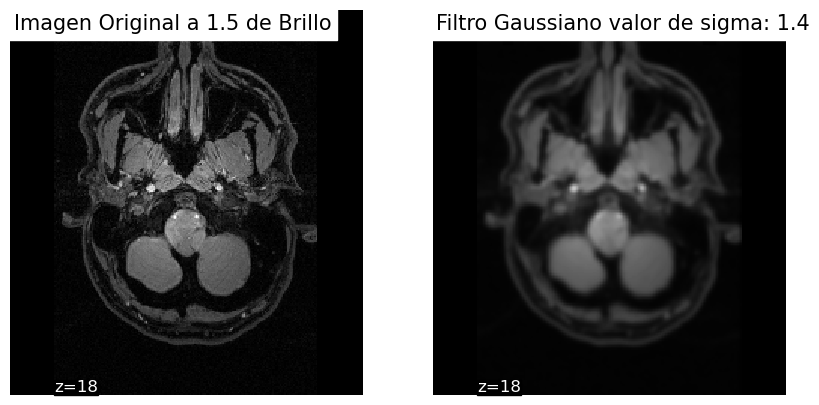

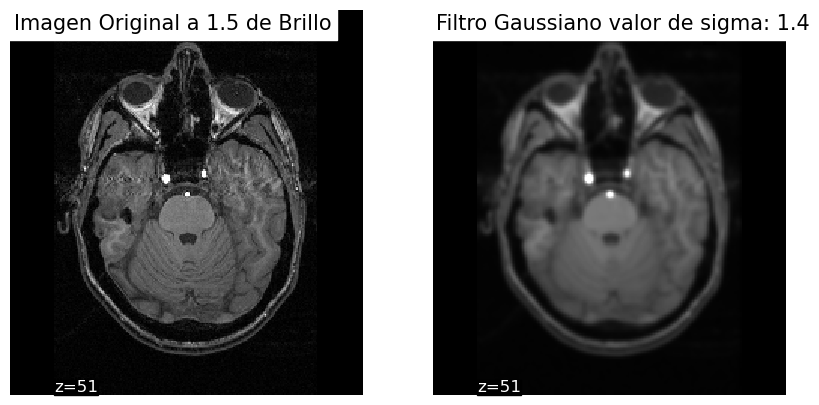

In [22]:
FuncionFiltros(0,"SubjectA_T1.nii.gz",sigma=1.4,Guardar=0,Graficar=1,cortes_z=[18,51])

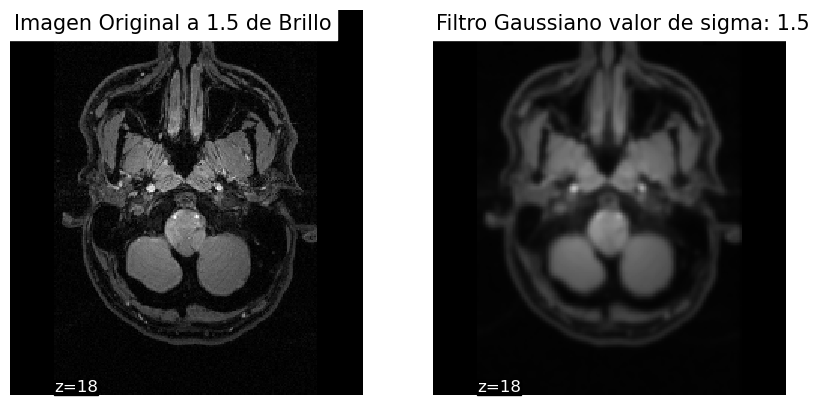

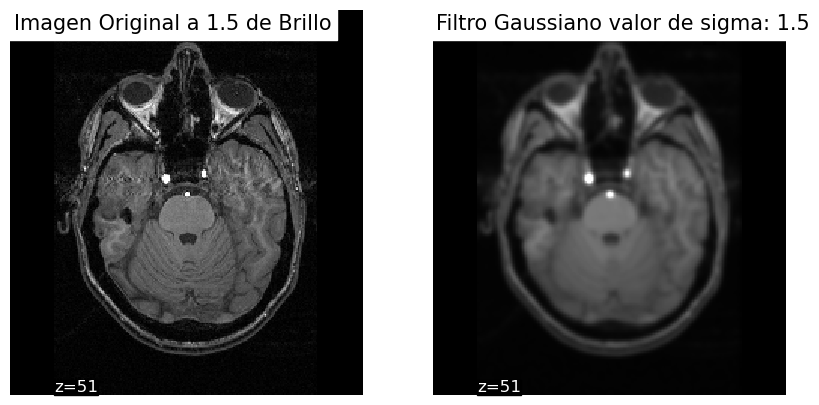

In [26]:
FuncionFiltros(0,"SubjectA_T1.nii.gz",sigma=1.5,Guardar=0,Graficar=1,cortes_z=[18,51])

IMPLEMENTACION DEL FILTRO DE MEDINANA CON DIFERENTES VALORES DE SIGMA

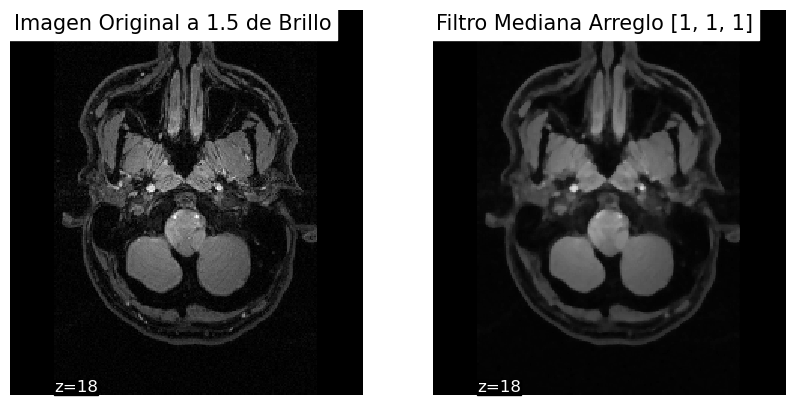

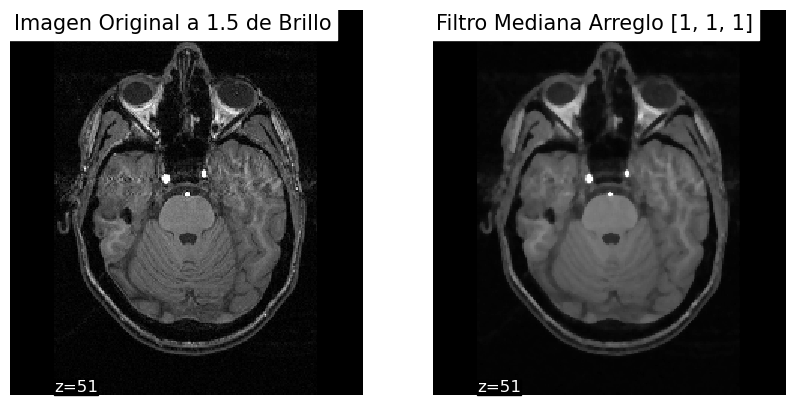

In [25]:
FuncionFiltros(1,"SubjectA_T1.nii.gz",Arreglo=[1,1,1],Guardar=0,Graficar=1,cortes_z=[18,51])

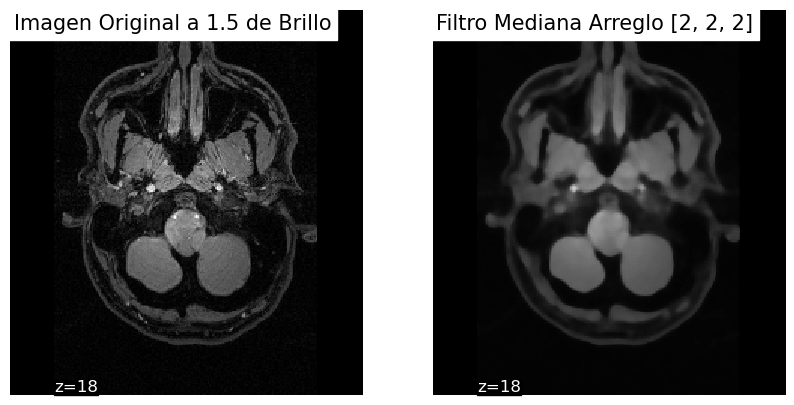

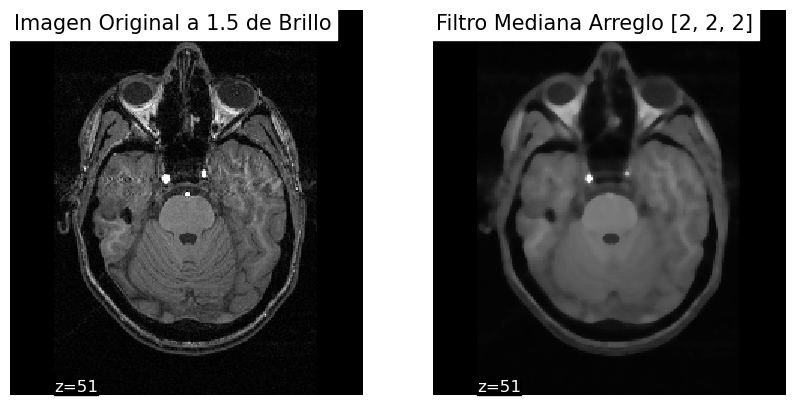

In [29]:
FuncionFiltros(1,"SubjectA_T1.nii.gz",Arreglo=[2,2,2],Guardar=0,Graficar=1,cortes_z=[18,51])

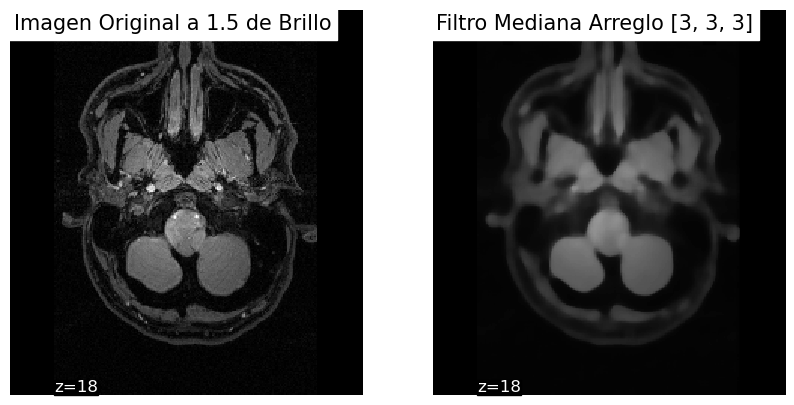

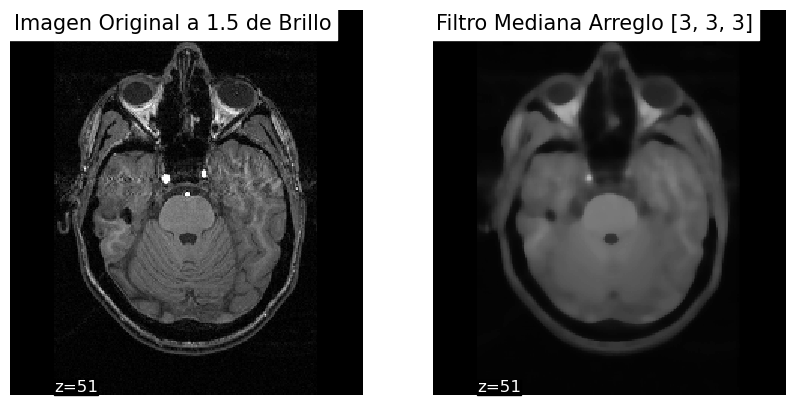

In [32]:
FuncionFiltros(1,"SubjectA_T1.nii.gz",Arreglo=[3,3,3],Guardar=0,Graficar=1,cortes_z=[18,51])

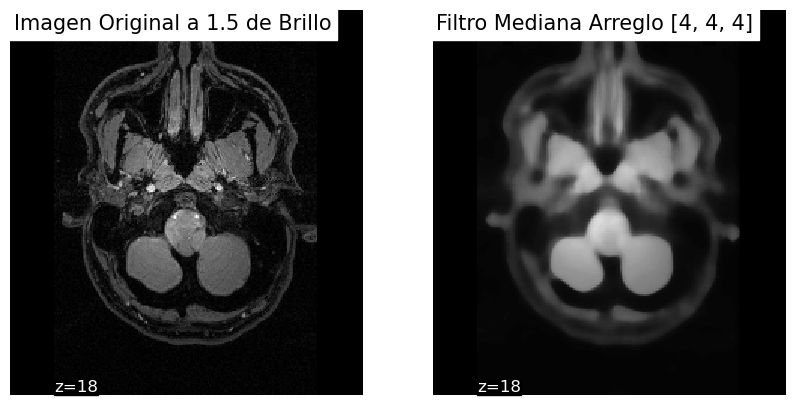

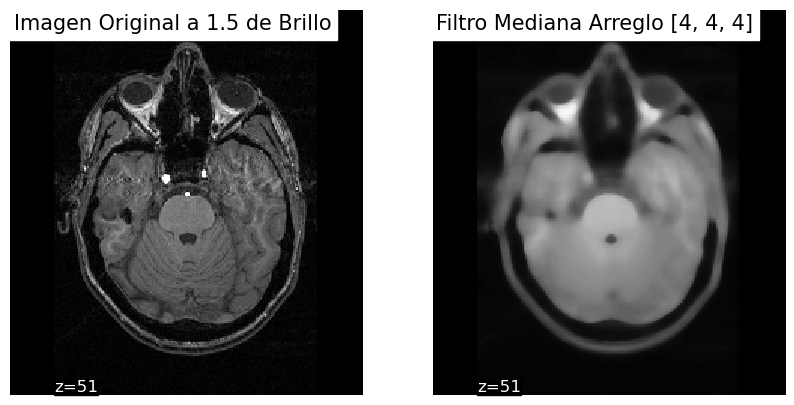

In [33]:
FuncionFiltros(1,"SubjectA_T1.nii.gz",Arreglo=[4,4,4],Guardar=0,Graficar=1,cortes_z=[18,51])

## Registro de imágenes

* Registro rígido




In [10]:
# Cargar las imágenes fija y móvil
fixed_image = itk.imread("/content/SubjectA_T1.nii.gz", itk.F)
moving_image = itk.imread("/content/SubjectA_T2.nii.gz", itk.F)

# Import Default Parameter Map
parameter_object = itk.ParameterObject.New()
default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid')
parameter_object.AddParameterMap(default_rigid_parameter_map)

# Call registration function
result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image,
    parameter_object=parameter_object,
    log_to_console=False)

In [11]:
print(result_transform_parameters)

ParameterObject (0x555e7f55ff30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34069
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 87.5 127.5 87.5)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParameterFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin 0 0 0)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 176 256 176)
  (Spacing 1 1 1)
  (Transform "EulerTransform")
  (TransformParameters 0.18066 0.000708227 -0.00113613 8.04244 1.41715 -37.2463)
  (UseDirectionCosines "true")



* Registro afín

In [ ]:
# Cargar las imágenes fija y móvil
fixed_image_affine = itk.imread("/content/SubjectA_T1.nii.gz", itk.F)
moving_image_affine = itk.imread("/content/SubjectA_T2.nii.gz", itk.F)

# Import Default Parameter Map
parameter_object = itk.ParameterObject.New()
default_affine_parameter_map = parameter_object.GetDefaultParameterMap('affine',4)
default_affine_parameter_map['FinalBSplineInterpolationOrder'] = ['0']
parameter_object.AddParameterMap(default_affine_parameter_map)

# Call registration function
result_image_affine, result_transform_parameters = itk.elastix_registration_method(
    fixed_image_affine, moving_image_affine,
    parameter_object=parameter_object,
    log_to_console=True)

* Registro Bspline

In [ ]:
# Import Default Parameter Map
parameter_object = itk.ParameterObject.New()
default_affine_parameter_map = parameter_object.GetDefaultParameterMap('affine',4)
default_affine_parameter_map['FinalBSplineInterpolationOrder'] = ['1']
parameter_object.AddParameterMap(default_affine_parameter_map)
default_bspline_parameter_map = parameter_object.GetDefaultParameterMap('bspline',4)
default_bspline_parameter_map['FinalBSplineInterpolationOrder'] = ['1']
parameter_object.AddParameterMap(default_bspline_parameter_map)

# Call registration function
result_image_bspline, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image,
    parameter_object=parameter_object,
    log_to_console=True)

In [ ]:
# Guardar las imágenes registradas
output_file = "imagen_registrada_rigido.nii.gz"
itk.imwrite(result_image, output_file)
output_file = "imagen_registrada_afin.nii.gz"
itk.imwrite(result_image_affine, output_file)
output_file = "imagen_registrada_Bspline.nii.gz"
itk.imwrite(result_image_bspline, output_file)


In [ ]:
from nilearn import image,plotting

# Rutas de las imágenes
imagen1_path = "/content/SubjectA_T2.nii.gz"
imagen2_path = "/content/SubjectA_T1.nii.gz"

# Cargar las imágenes con Nilearn
imagen1 = image.load_img(imagen1_path)
imagen2 = image.load_img(imagen2_path)

# Visualizar la primera imagen
display = plotting.plot_anat(imagen1, display_mode='ortho', cmap='gray')

# Superponer la segunda imagen con cierto nivel de transparencia
display.add_overlay(imagen2, cmap='hot', alpha=0.5)

# Mostrar el resultado
plotting.show()


In [ ]:
# Para el afín

# Rutas de las imágenes
imagen1_path = "/content/imagen_registrada_afin.nii.gz"
imagen2_path = "/content/SubjectA_T1.nii.gz"

# Cargar las imágenes con Nilearn
imagen1 = image.load_img(imagen1_path)
imagen2 = image.load_img(imagen2_path)

# Visualizar la primera imagen
display = plotting.plot_anat(imagen1, display_mode='ortho', cmap='gray')

# Superponer la segunda imagen con cierto nivel de transparencia
display.add_overlay(imagen2, cmap='hot', alpha=0.5)

# Mostrar el resultado
plotting.show()

In [ ]:
# Para el Bspline

# Rutas de las imágenes
imagen1_path = "/content/imagen_registrada_Bspline.nii.gz"
imagen2_path = "/content/SubjectA_T1.nii.gz"

# Cargar las imágenes con Nilearn
imagen1 = image.load_img(imagen1_path)
imagen2 = image.load_img(imagen2_path)

# Visualizar la primera imagen
display = plotting.plot_anat(imagen1, display_mode='ortho', cmap='gray')

# Superponer la segunda imagen con cierto nivel de transparencia
display.add_overlay(imagen2, cmap='hot', alpha=0.5)

# Mostrar el resultado
plotting.show()

In [ ]:
from nilearn import masking

mask =masking.compute_multi_brain_mask([imagen2_path,imagen2_path], threshold=0.5, connected=True, opening=2, memory=None, verbose=0, n_jobs=1, mask_type='whole-brain')

In [ ]:
import matplotlib.pyplot as plt
from nilearn import plotting

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 4))

# Graficar la máscara utilizando nilearn con límites de visualización ajustados manualmente
plotting.plot_img(mask, display_mode='ortho')

plt.title('Máscara generada')
plt.show()


In [ ]:
!pip install nibabel

In [ ]:
import nibabel as nib

# Ruta de la imagen médica
imagen_path = "/content/SubjectA_T1.nii.gz"

# Cargar la imagen
imagen_nib = nib.load(imagen_path)

# Obtener los datos de la imagen
imagen_data = imagen_nib.get_fdata()

umbral_inferior = 10
umbral_superior = 30

# Aplicar umbrales
mascara = np.logical_and(imagen_data > umbral_inferior, imagen_data < umbral_superior)


import matplotlib.pyplot as plt

# Visualizar la imagen original
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imagen_data[:, :, imagen_data.shape[2] // 2], cmap='gray')
plt.title('Imagen Original')

# Visualizar la máscara segmentada
plt.subplot(1, 2, 2)
plt.imshow(mascara[:, :, imagen_data.shape[2] // 2], cmap='binary')
plt.title('Máscara Segmentada')

plt.show()
